In [1]:
import os 
import glob
import pandas as pd 
import numpy as np
from linkageTree import linkageCut
from TSP_Formulation_Methods import ( 
    create_QUBO_matrix,
    solve_qubo_with_Dwave,
    check_solution, 
    load_lambda_means,
    draw_solution_graph,
)
from vqaa_tools import ( 
    heuristical_embedding, 
    atoms_register,
    atoms_list, 
    generate_grid,
    run_vqaa,
    plot_distribution,
)
from utils import ( 
    view_linkage_on_map, 
    draw_centers_on_map,
    map_draw_line,
    convert_bitstring_to_matrix
)

# Load initial data 

In [2]:
# Load previously stored overpy lat/lon datafile for different amenities
amenities_data = pd.read_csv(os.path.join(os.curdir, 'data', 'amenities-granada.csv'))
# Create a hierarchical clustering of amenities
hierarchical_cluster = linkageCut(amenities_data)
# Set a specific number of clusters per levels
nclusters = 6
levels = 2
labels = hierarchical_cluster.top_down_view_recur(nclusters=6, levels=2)
# Visualize for debugging purposes.
view_linkage_on_map(linkage_matrix=hierarchical_cluster)

# First iteration

In [3]:
# Fetch the centers of the first level
centers = hierarchical_cluster.give_centers_level(0)
# Sanity check by drawing the graph
draw_centers_on_map(centers)

In [4]:
# Fetch the distance from the centers of the first level
distances = hierarchical_cluster.dist_matrix_level(0, return_labels=False)
# Set initial global parameters
N = distances.shape[0]
p = 3

startNode = 0
endNode = np.random.choice(np.arange(distances.shape[0] - 1) + 1)

# Process Parameters
p = min(p, N-1)
startNode = min(startNode, N-1)
endNode = min(endNode, N-1)

reduced_distances = distances[:N,:N]/np.max(distances[:N,:N])
maxDistance = np.max(reduced_distances)
lambda_paths = glob.glob(os.path.join('data', 'lamdasOptimized', '*'))
mean_lambdas = load_lambda_means(lambda_paths)

# Formulation with initial lambdas
Q_matrix_initial,_ = create_QUBO_matrix(reduced_distances, p, startNode, endNode, mean_lambdas)

In [5]:
solution_Dwave, _ = solve_qubo_with_Dwave(Q_matrix_initial, num_reads=1000)
print("\nD-Wave solution:")
print(solution_Dwave)
check_solution(solution_Dwave, N,  p, startNode, endNode)


D-Wave solution:
[1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0]


In [6]:
adjacency = convert_bitstring_to_matrix(solution_Dwave, N=N, p=p)
map_draw_line(centers[:, ::-1], adjacency, color='red')

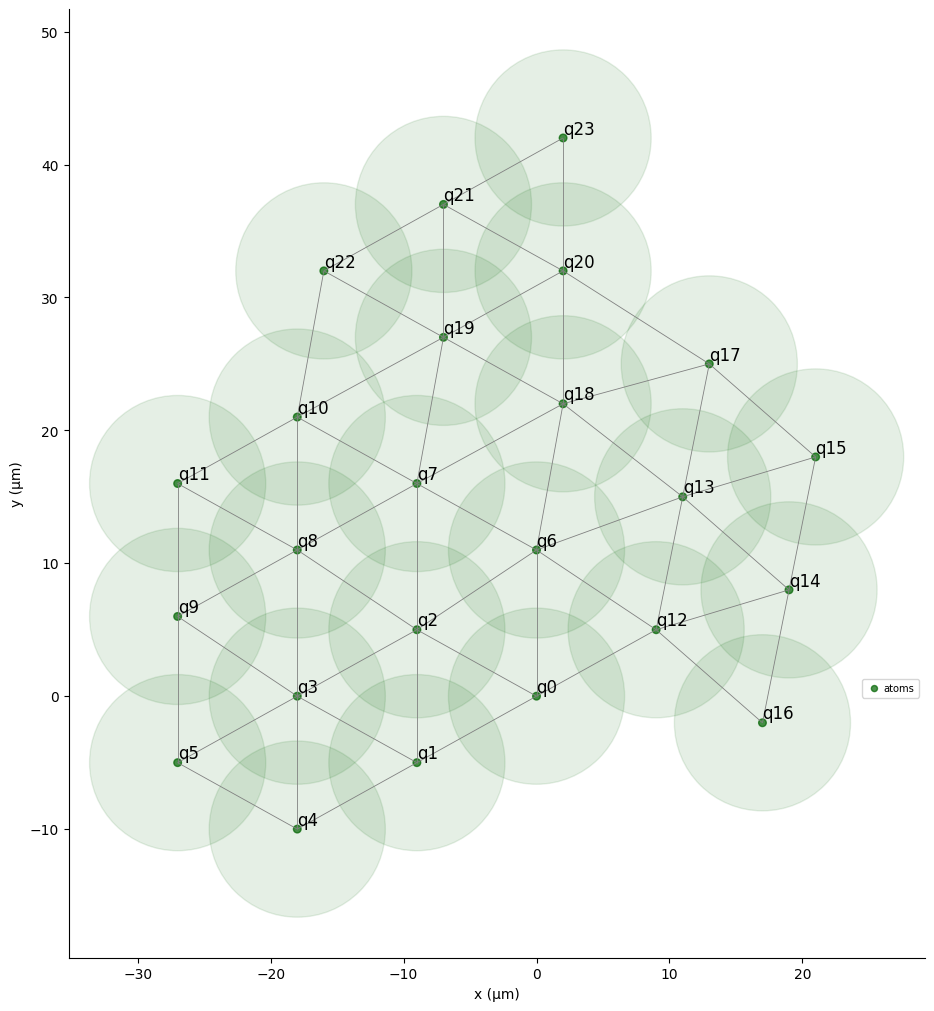

In [7]:
coords = heuristical_embedding(atoms_list(len(Q_matrix_initial)), generate_grid(50, 50,1), Q_matrix_initial)
register = atoms_register(coords)

In [ ]:
# Why is it takiung > 5minutes????
C, x = run_vqaa(Q_matrix_initial, register)

[3.93761638 1.45923004]


KeyboardInterrupt: 

# Second iteration

In [ ]:
connections = np.concatenate([adjacency[:,0].nonzero()[0], adjacency[0, :].nonzero()[0]], axis=0)
print(connections)
# Fetch the centers of the first level
distances, _ = hierarchical_cluster.dist_matrix_label_down(
    1,
    connections=connections,
)
print(distances)

[4]
[[0.     3.5573 3.8845 4.1117 3.2771 3.0454]
 [3.5573 0.     2.2052 3.07   3.1322 3.0128]
 [3.8845 2.2052 0.     3.1783 2.9205 3.8149]
 [4.1117 3.07   3.1783 0.     2.3242 2.697 ]
 [3.2771 3.1322 2.9205 2.3242 0.     1.7267]
 [3.0454 3.0128 3.8149 2.697  1.7267 0.    ]]
